# Image classification using tensorflow pre-trained model

Tensorflow-Slim image classification model library provides both the implementation and pre-trianed checkpoint many popular convolution neural nets for image classification.

Using TFNet in Analytics-Zoo, we can easily load these pre-trained model and make distributed inference with only a few lines of code.

## Add the slim image classification model library to $PYTHONPATH

In [1]:
#from bigdl.util.common import *
#init_engine()
import re
from bigdl.nn.criterion import CrossEntropyCriterion
from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, StringType
from zoo.common.nncontext import *
from zoo.feature.image import *
from zoo.pipeline.api.keras.layers import Dense, Input, Flatten
from zoo.pipeline.api.keras.models import *
from zoo.pipeline.api.net import *
from zoo.pipeline.nnframes import *
#sc = init_nncontext(create_spark_conf().setAppName("Image Classification Example"))
sparkConf = SparkConf().setAppName("ImageTransferLearningExample")
sc = init_nncontext(sparkConf)
############################
import sys
import tensorflow as tf
sys.path
slim_path = "/path/to/yourdownload/models/research/slim" # Please set this to the directory where you clone the tensorflow models repository
sys.path.append(slim_path)

creating: createDefault
creating: createSGD
creating: createSeqToTensor
creating: createSeqToTensor
creating: createSeqToTensor
creating: createSeqToTensor
creating: createSeqToTensor


## Construct the inference graph and restore the checkpoint

In [2]:
from datasets import dataset_factory
from nets import inception
slim = tf.contrib.slim

image = tf.random_uniform(shape=[224, 224, 3])
batch_size_tensor = tf.placeholder_with_default(32, shape=())
images = tf.train.batch(
    [image],
    batch_size=batch_size_tensor,
    num_threads=4,
    capacity=5 * 32)
# One thing to note is that the batch_size must be placeholder, so that batch size is not hard coded into graph and analytics-zoo can work on different batch sizes.
# The above code can be replaced with a single line of code
# images = tf.placeholder(dtype=tf.float32, shape=(None, 224, 224, 3))

with slim.arg_scope(inception.inception_v1_arg_scope()):
    logits, end_points = inception.inception_v1(images, num_classes=1001, is_training=False)

sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "/path/to/yourdownload/checkpoint/inception_v1.ckpt") # You need to edit this path to the checkpoint you downloaded

INFO:tensorflow:Restoring parameters from /home/ludviq/workspace/checkpoint/inception_v1.ckpt


## Export the graph as a frozen inference graph

The export_tf utility function will frozen the tensorflow graph, strip unused operation according to the inputs and outputs and save it to the specified directory along with the input/output tensor names.

In [3]:
from zoo.util.tf import export_tf
export_tf(sess, "/path/to/yourdownload/models/tfnet/", inputs=[images], outputs=[logits])

INFO:tensorflow:Froze 230 variables.
Converted 230 variables to const ops.


## Load to Analytics-Zoo

In [4]:
from zoo.pipeline.api.net import TFNet
model = TFNet.from_export_folder("/path/to/yourdownload/models/tfnet")

creating: createTFNet


## Test it on one image

![Test Image](./test.jpg)

In [5]:
import cv2
import numpy as np
import json
im = cv2.imread("test.jpg")
im = cv2.resize(im, (224, 224))
im = (im - 127.0) / 128.0
im = np.expand_dims(im, 0)

In [6]:
import json
with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [7]:
import numpy as np
result = model.predict([im])
print(idx2label[np.argmax(result, 1)[0]])

Persian_cat


## Fine tune on the data

### Construct the inference graph and restore the checkpoint

In [8]:
tf.reset_default_graph()# if you want to test your code, you can use it to reset your graph and to avoid some mistakes

image = tf.random_uniform(shape=[224, 224, 3])
batch_size_tensor = tf.placeholder_with_default(32, shape=())
images = tf.train.batch(
    [image],
    batch_size=batch_size_tensor,
    num_threads=4,
    capacity=5 * 32)
# One thing to note is that the batch_size must be placeholder, so that batch size is not hard coded into graph and analytics-zoo can work on different batch sizes.
# The above code can be replaced with a single line of code
#images = tf.placeholder(dtype=tf.float32, shape=(None, 224, 224, 3))

with slim.arg_scope(inception.inception_v1_arg_scope()):
    logits, end_points = inception.inception_v1(images, num_classes=1001)

sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "/path/to/yourdownload/checkpoint/inception_v1.ckpt")# You need to edit this path to the checkpoint you downloaded

INFO:tensorflow:Restoring parameters from /home/ludviq/workspace/checkpoint/inception_v1.ckpt


### Remove the dense layer of the graph(Inception_v1) and export the graph left as a frozen inference graph

The export_tf utility function will frozen the tensorflow graph, strip unused operation according to the inputs and outputs and save it to the specified directory along with the input/output tensor names. In this example, we use the "AvgPool_0a_7x7" as our end_points, freeze the graph accoring to "AvgPool_0a_7x7" and export this graph to the specific directory

In [9]:
from zoo.util.tf import export_tf
avg_pool = end_points['AvgPool_0a_7x7']
export_tf(sess, "/path/to/yourdownload/models/tfnet/", inputs=[images], outputs=[avg_pool])

INFO:tensorflow:Froze 114 variables.
Converted 114 variables to const ops.


### Load to Analytics-Zoo

Load that freezed graph from the specific directory above

In [10]:
from zoo.pipeline.api.net import TFNet
amodel = TFNet.from_export_folder("/path/to/yourdownload/models/tfnet/")

creating: createTFNet


### Add the layers you want to the model

Use sequential model to build your model. First transport the type of data from NCHW to NHWC. Then multiply the scalar and make the input and output both contiguous. Add the freezed graph and add a linear layer after the graph.

In [11]:
from bigdl.nn.layer import Sequential,Transpose,Contiguous,Linear,ReLU, SoftMax, Reshape, View, MulConstant, SpatialAveragePooling
full_model = Sequential()
full_model.add(Transpose([(2,4), (2,3)]))
scalar = 1. /255
full_model.add(MulConstant(scalar))
full_model.add(Contiguous())
full_model.add(amodel)
full_model.add(View([1024]))
full_model.add(Linear(1024,2))

creating: createSequential
creating: createTranspose
creating: createMulConstant
creating: createContiguous
creating: createView
creating: createLinear


### get data

Set the path to the cat_dog data you downloaded. Then read these images from this path.
Use udf functions to design some functions to mark data.
Seperate the data into two groups: training data and validation data.

In [12]:
# import re
# from bigdl.nn.criterion import CrossEntropyCriterion
# from pyspark import SparkConf
# from pyspark.ml import Pipeline
# from pyspark.sql.functions import col, udf
# from pyspark.sql.types import DoubleType, StringType
# from zoo.common.nncontext import *
# from zoo.feature.image import *
# from zoo.pipeline.api.keras.layers import Dense, Input, Flatten
# from zoo.pipeline.api.keras.models import *
# from zoo.pipeline.api.net import *
# from zoo.pipeline.nnframes import *
# sc = init_nncontext(create_spark_conf().setAppName("Image Classification Example")) 
image_path = "file:///path/toyourdownload/dogs_vs_cats/minitrain/*.jpg"
imageDF = NNImageReader.readImages(image_path, sc)

getName = udf(lambda row:
                  re.search(r'(cat|dog)\.([\d]*)\.jpg', row[0], re.IGNORECASE).group(0),
                  StringType())
getLabel = udf(lambda name: 1.0 if name.startswith('cat') else 2.0, DoubleType())

labelDF = imageDF.withColumn("name", getName(col("image"))) \
        .withColumn("label", getLabel(col('name')))
(trainingDF, validationDF) = labelDF.randomSplit([0.9, 0.1])
labelDF.select("name","label").show(10)

+------------+-----+
|        name|label|
+------------+-----+
|cat.4304.jpg|  1.0|
|cat.8362.jpg|  1.0|
| cat.711.jpg|  1.0|
|cat.4361.jpg|  1.0|
|cat.1491.jpg|  1.0|
|cat.4931.jpg|  1.0|
|cat.5675.jpg|  1.0|
|dog.1551.jpg|  2.0|
|cat.7118.jpg|  1.0|
|dog.1495.jpg|  2.0|
+------------+-----+
only showing top 10 rows



### Show the distribution of Training Data

In [13]:
trainingDF.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   64|
|  2.0|   63|
+-----+-----+



### Using pipeline to train the data

Combine the preprocessing processes together. Before identify the classifier, design the summary's name to make sure we will store the log in right name. Identify the args of classifier. Then save logs to the dirctionary. Use the classifier identified just to create pipeline. Use this pipeline as your model to train the data.

In [14]:
transformer = ChainedPreprocessing(
        [RowToImageFeature(), ImageResize(224, 224),
         ImageChannelNormalize(123.0, 117.0, 104.0), ImageMatToTensor(), ImageFeatureToTensor()])

from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *
import datetime as dt
app_name='classification cat vs dog'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='./log/',
                                     app_name=app_name)
classifier = NNClassifier(full_model, CrossEntropyCriterion(), transformer)\
        .setFeaturesCol("image")\
        .setLearningRate(0.003)\
        .setBatchSize(16)\
        .setMaxEpoch(9)\
        .setTrainSummary(train_summary)
# BatchSize is a multiple of physcial_core_number(in your bash command)

from pyspark.ml import Pipeline
import os
import datetime as dt
if not os.path.exists("./log"):
    os.makedirs("./log")
    
print("Saving logs to ", app_name)
pipeline = Pipeline(stages=[classifier])
trainedModel = pipeline.fit(trainingDF)

creating: createRowToImageFeature
creating: createImageResize
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing
creating: createTrainSummary
creating: createCrossEntropyCriterion
creating: createScalarToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier
('Saving logs to ', 'classification cat vs dog20180731-122143')
creating: createToTuple
creating: createChainedPreprocessing


### Test the model on validation data

Use the vallidation data to test the model, and print the test error

In [15]:
# predict using the validation data
predictionDF = trainedModel.transform(validationDF).cache()
# caculate the correct rate and the test error
correct = predictionDF.filter("label=prediction").count()
overall = predictionDF.count()
accuracy = correct * 1.0 / overall

print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0 


Make the pic can be seen on this page. Repeatedly run this code without restart the kernel will result in a warning.

In [16]:
# get a pic about the result and make it can show in GUI
import matplotlib
matplotlib.use('Agg')
%pylab inline

from matplotlib.pyplot import imshow

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Show the change in loss using a pic.

Text(0.5,1,'loss')

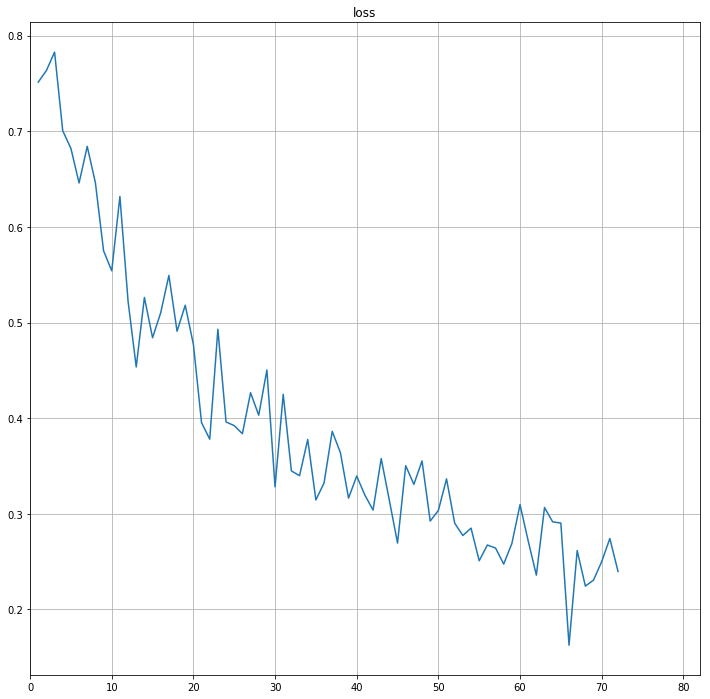

In [17]:
# read loss from summary nad show in pic
loss = np.array(train_summary.read_scalar("Loss"))
plt.figure(figsize = (12,12))
plt.plot(loss[:,0], loss[:,1], label='loss')
plt.xlim(0, loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

Collect two examples from both sides.

In [18]:
samplecat=predictionDF.filter(predictionDF.prediction==1.0).limit(2).collect()
sampledog=predictionDF.filter(predictionDF.prediction==2.0).sort("label", ascending=False).limit(2).collect()

Show two cat-pics and their predictions.

prediction: 1.0


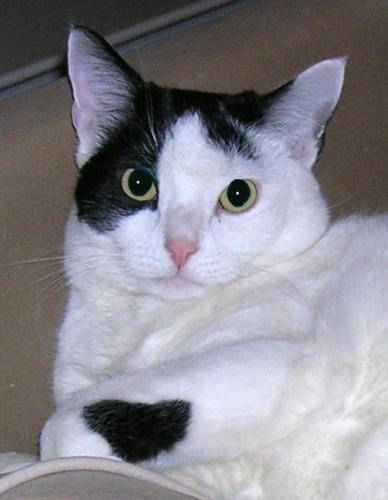

prediction: 1.0


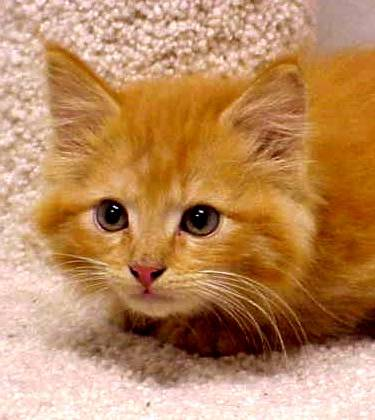

In [19]:
from IPython.display import Image, display
for cat in samplecat:
    print ("prediction:"), cat.prediction
    display(Image(cat.image.origin[5:], height=256,width=256))

Show two dog-pics and their predictions.

prediction: 2.0


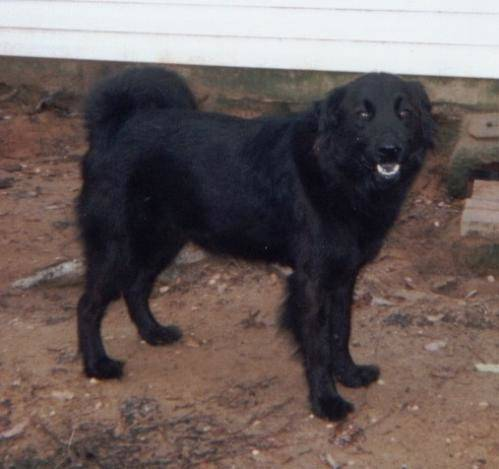

prediction: 2.0


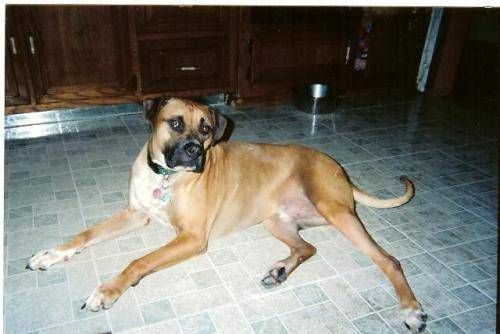

In [20]:
# show the two pics and their things as follow
from IPython.display import Image, display
for dog in sampledog:
    print ("prediction:"), dog.prediction
    
    display(Image(dog.image.origin[5:], height=256,width=256))